# Setup Library


In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from yellowbrick.regressor import prediction_error, residuals_plot

from typing import Dict
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
df = pd.read_csv("./data/gemstone.csv")
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


# Data Quality

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In our dataset, we didn't find some issues about dtype

In [4]:
print("Check Null")
print(df.isnull().sum(), "\n")

print("Checking Duplicated")
df.duplicated(subset="id").sum()

Check Null
id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64 

Checking Duplicated


0

We not have data missing and not have duplicate in ourdataset

In [5]:
#summary statistics
df.describe()

,id,carat,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
mean,96786.000000,0.790688,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,55879.856166,0.462688,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.000000,0.200000,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,48393.000000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,96786.000000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,145179.000000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000
max,193572.000000,3.500000,71.600000,79.000000,9.650000,10.010000,31.300000,18818.000000


- We found some issues with the dimensions X, Y, and Z where the values are 0, as well as some outliers in the Z dimension. This does not make sense because diamonds are 3D objects.
- A Z measurement of 31.3 for a diamond does not make sense. Diamonds are three-dimensional objects with certain proportions, and the height of a diamond (dimension Z) is usually not significantly larger than its length and width (dimensions X and Y). The given dimensions indicate that the height of the diamond (31.3 mm) is much larger than its length (5.2 mm) and width (5.13 mm), which is inconsistent with the normal physical structure of a diamond.

We need to filter these data points before we continue with the analysis.

In [6]:
# filter data X, Y , Z are 0 
condition = (df["x"]!=0)
condition_2 = (df["y"]!=0)
condition_3 = (df["z"]!=0)

print(f"data size before cleaning {df.shape[0]}")
df = df[condition]
df = df[condition_2]
df = df[condition_3].reset_index(drop=True)
df = df[df["z"]<30].reset_index(drop=True)
print(f"data size after cleaning {df.shape[0]}")

data size before cleaning 193573
data size after cleaning 193562


In [7]:
df.describe()

,id,carat,depth,table,x,y,z,price
count,193562.000000,193562.000000,193562.000000,193562.000000,193562.000000,193562.000000,193562.000000,193562.000000
mean,96784.872687,0.790646,61.820608,57.227543,5.715314,5.720064,3.534285,3968.871716
std,55879.809239,0.462635,1.081661,1.918791,1.109119,1.102106,0.685575,4034.026563
min,0.000000,0.200000,52.100000,49.000000,3.750000,3.710000,1.050000,326.000000
25%,48392.250000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000,950.000000
50%,96783.500000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,145176.750000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000,5407.750000
max,193572.000000,3.500000,71.600000,79.000000,9.650000,10.010000,8.400000,18818.000000



* **Mean:** This represents the average value for each column. For instance, the average carat weight is 0.54, and the average price is $1227.40.
* **Std (Standard Deviation):** This indicates how spread out the data points are from the mean. A high standard deviation suggests a wider range of values, while a low standard deviation means the data points are clustered closer to the mean. Here, the standard deviation for price is quite high ($935.96) compared to the mean, implying a significant variation in diamond prices.
* **Min (Minimum):** This shows the lowest value for each variable. The smallest diamond has a carat weight of 0.20 and was priced at $326.
* **Q1 (1st Quartile):** This represents the value where 25% of the data falls below it. Halfway between the minimum and the median. 
* **Median:** This is the middle value when the data is ordered from least to greatest. It provides a better sense of the "typical" value compared to the mean which can be skewed by outliers. Here, the median carat weight is 0.50 and the median price is $993.
* **Q3 (3rd Quartile):** This represents the value where 75% of the data falls below it. Halfway between the median and the maximum.
* **Max (Maximum):** This shows the highest value for each variable. The largest diamond has a carat weight of 1.00 and was priced at $2785.

**Key points to consider:**

* There seems to be a positive correlation between carat weight and price, as the mean price increases with carat weight. 
* The price data has a high standard deviation, indicating a large spread in prices. This suggests significant price variations even for diamonds with similar carat weights. 



# Eksploratory Data Analytics

In [8]:
con_var = [
    var for var in df.columns if df[var].dtype !="O" and df[var].nunique()>20 and var!="id" and var!="price"
]

dis_var = [
    var for var in df.columns if df[var].dtype !="O"  and df[var].nunique()<=20 and var!="id"
]

cat_var = [
    var for var in df.columns if df[var].dtype =="O" 
]

print(f'Continuous Variable are {" ".join(con_var)}')
print(f'Discreate Variable are {" ".join(dis_var)}')
print(f'Categorical Variable are {" ".join(cat_var)}')

Continuous Variable are carat depth table x y z
Discreate Variable are 
Categorical Variable are cut color clarity


# Univariate

Focus on distribution data

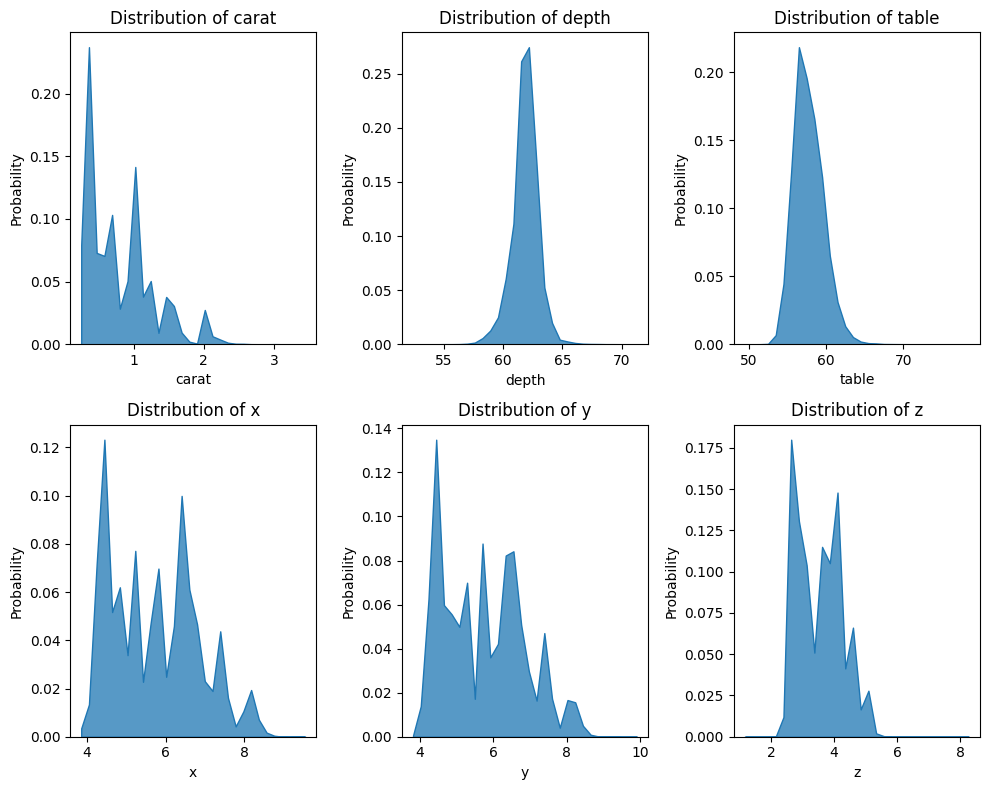

In [9]:
plt.figure(figsize=(10,8))

for i in range(1,len(con_var)+1):
    plt.subplot(2,3,i)
    sns.histplot(data=df,x=con_var[i-1],bins=30,stat="probability",element="poly")
    plt.title(f"Distribution of {con_var[i-1]}")

plt.tight_layout()
plt.show()

* **Carat:** The distribution of carat weight appears to be somewhat skewed to the right. This means there may be more diamonds with lower carat weights compared to higher carat weights. 
* **Depth:** The distribution of depth appears to be roughly symmetrical and bell-shaped, which suggests it might be normally distributed. 
* **Table:** The distribution of table size also appears to be symmetrical and bell-shaped, possibly indicating a normal distribution.
* **x,y,z dimension** The distributions of x, y, and z (length, width, and depth) are likely to be right-skewed, similar to carat and depth. This is because most diamonds tend to be smaller in size, with fewer larger diamonds.

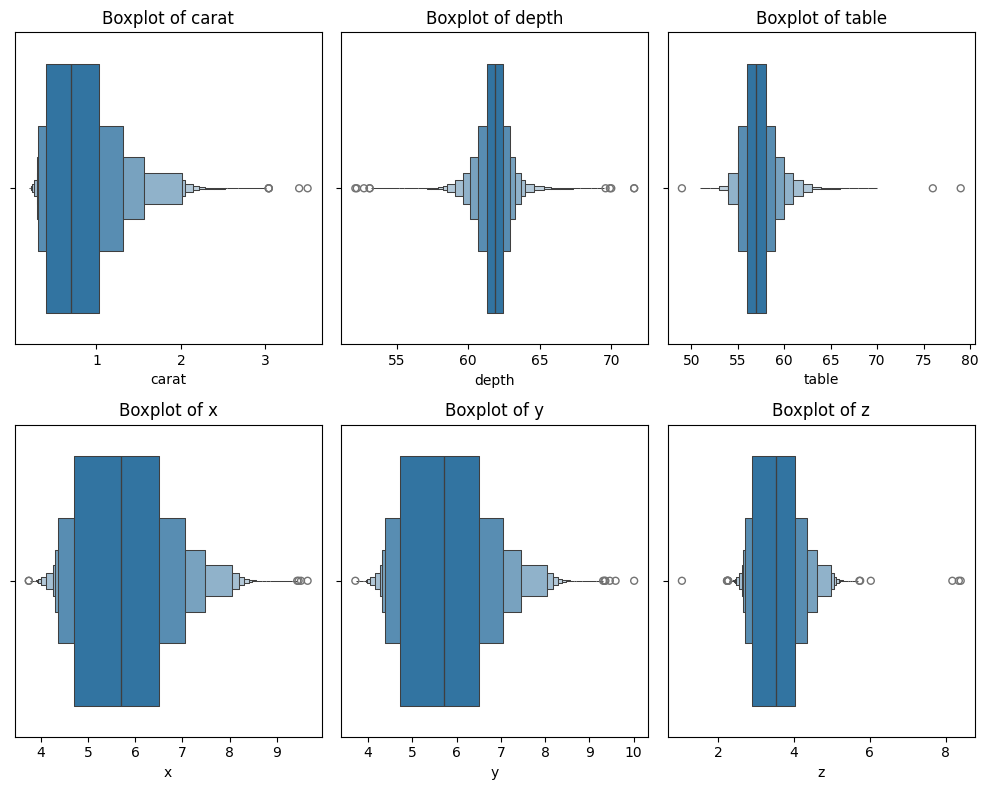

In [10]:
plt.figure(figsize=(10,8))

for i in range(1,len(con_var)+1):
    plt.subplot(2,3,i)
    sns.boxenplot(x=df[con_var[i-1]])
    plt.title(f"Boxplot of {con_var[i-1]}")

plt.tight_layout()
plt.show()

**Carat, depth, and table:**

* These features show similar distributions with the majority of diamonds concentrated towards the lower end of the value range.
* There are several outliers in all three features, indicating the presence of some unusually large or deep diamonds and some with unusually large table sizes.

**x, y, and z (dimensions of the diamonds):**

* These features exhibit a similar pattern to carat, depth, and table, with the majority of diamonds having smaller dimensions.
* The interquartile range (IQR) for these dimensions is smaller than that of carat, depth, and table, suggesting that the diamond dimensions are more consistent compared to the other features.
* There are a few outliers in x,y and z dimensions, but fewer than those seen in carat, depth, and table.



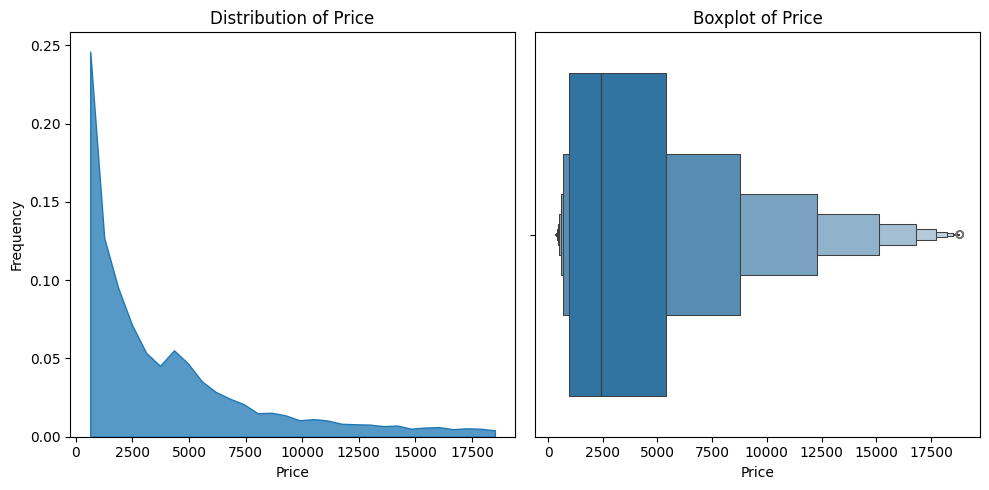

In [11]:
# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(df["price"],bins=30,stat="probability",element="poly", ax=axs[0])
axs[0].set_title('Distribution of Price')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')


sns.boxenplot(x=df["price"], ax=axs[1])
axs[1].set_title('Boxplot of Price')
axs[1].set_xlabel('Price')


plt.tight_layout()

plt.show()

<Axes: xlabel='price', ylabel='Probability'>

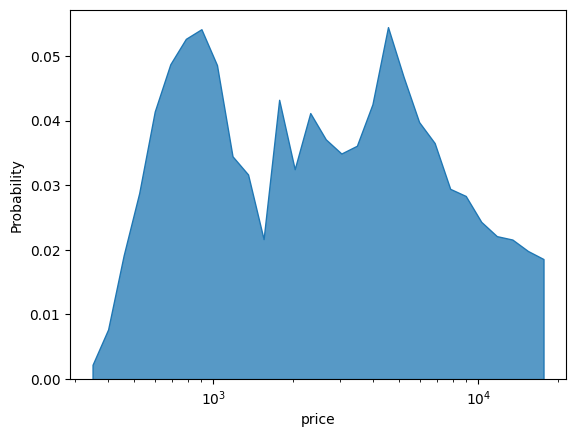

In [12]:
sns.histplot(data=df,x=df["price"],bins=30,stat="probability",element="poly",log_scale=True)

1. **Multimodal Distribution:** The distribution isn't a simple bell curve. It has several peaks, suggesting distinct price ranges where diamonds are more commonly found.
2. **Peak Clusters:** Prominent peaks occur around $700-$1000, $2500-$3000, and $5000. This suggests diamonds are frequently priced within these ranges.
3. **Lower Price Density:**  Prices below $500 are less common, as indicated by the lower probability density in that region.
4. **Higher Price Scarcity:**  Prices above $10,000 are increasingly rare, reflected in the rapidly declining density towards the right tail of the distribution.


# Deep Dive

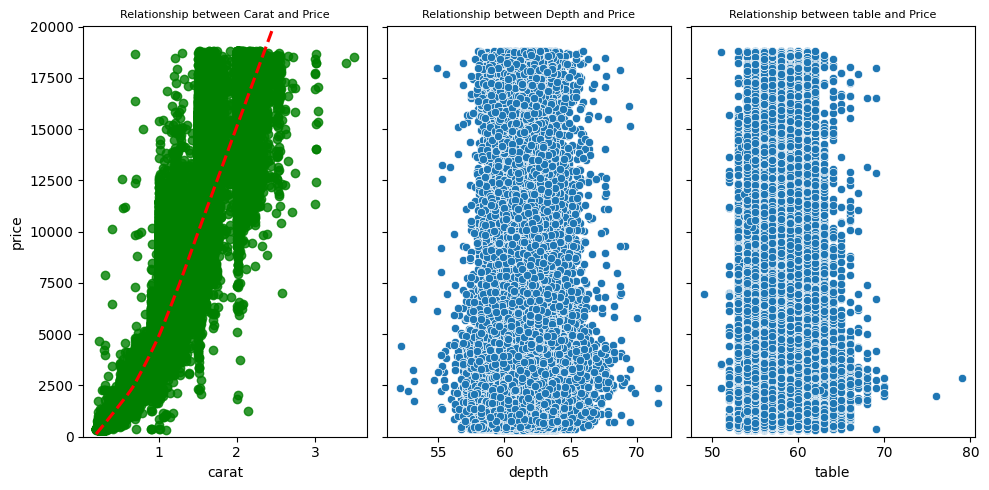

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5),sharey=True)

sns.regplot(
    data=df,
    x="carat",
    y="price",
    scatter_kws={"color":"green"},
    line_kws={"color":"red","linestyle":"dashed"},
    lowess=True,
    ax=axs[0]
).set_title("Relationship between Carat and Price",fontsize=8)

sns.scatterplot(
    data=df,
    x="depth",
    y="price",
    ax=axs[1]
).set_title("Relationship between Depth and Price",fontsize=8)

sns.scatterplot(
    data=df,
    x="table",
    y="price",
    ax=axs[2]
).set_title("Relationship between table and Price",fontsize=8)

plt.ylim([0,2e4+10])
plt.tight_layout()
plt.show()

- Carat weight is a significant factor in determining diamond prices, with larger diamonds being exponentially more expensive.
- Depth and Table percentage have a minimal impact on diamond prices, indicating that other factors play a more significant role in determining price

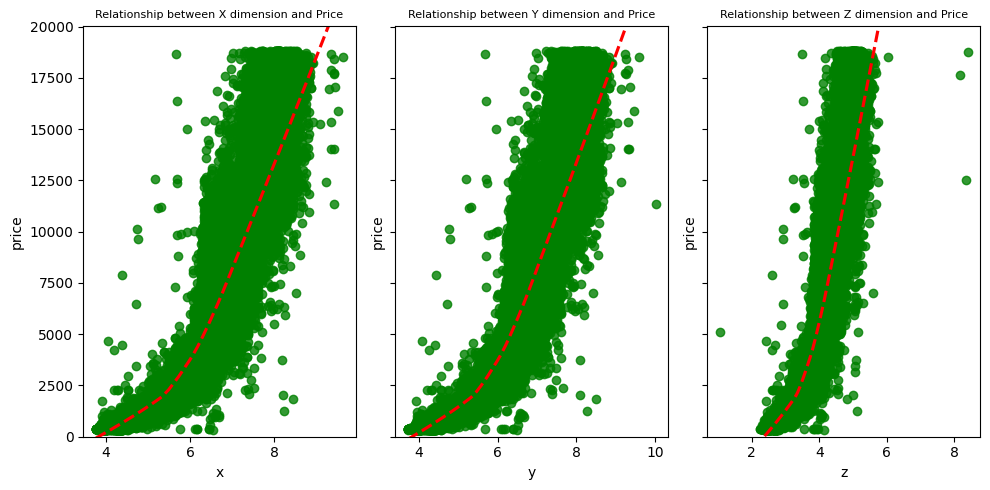

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5),sharey=True)

sns.regplot(
    data=df,
    x="x",
    y="price",
    scatter_kws={"color":"green"},
    line_kws={"color":"red","linestyle":"dashed"},
    lowess=True,
    ax=axs[0]
).set_title("Relationship between X dimension and Price",fontsize=8)

sns.regplot(
    data=df,
    x="y",
    y="price",
    scatter_kws={"color":"green"},
    line_kws={"color":"red","linestyle":"dashed"},
    lowess=True,
    ax=axs[1]
).set_title("Relationship between Y dimension and Price",fontsize=8)

sns.regplot(
    data=df,
    x="z",
    y="price",
    scatter_kws={"color":"green"},
    line_kws={"color":"red","linestyle":"dashed"},
    lowess=True,
    ax=axs[2]
).set_title("Relationship between Z dimension and Price",fontsize=8)

plt.ylim([0,2e4+10])
plt.tight_layout()
plt.show()

- All three dimensions (x, y, z) show a positive correlation with price, indicating that larger diamonds generally command higher prices.
- The relationship between dimensions and price is not strictly linear, particularly for length and width, suggesting that larger diamonds are disproportionately more expensive.

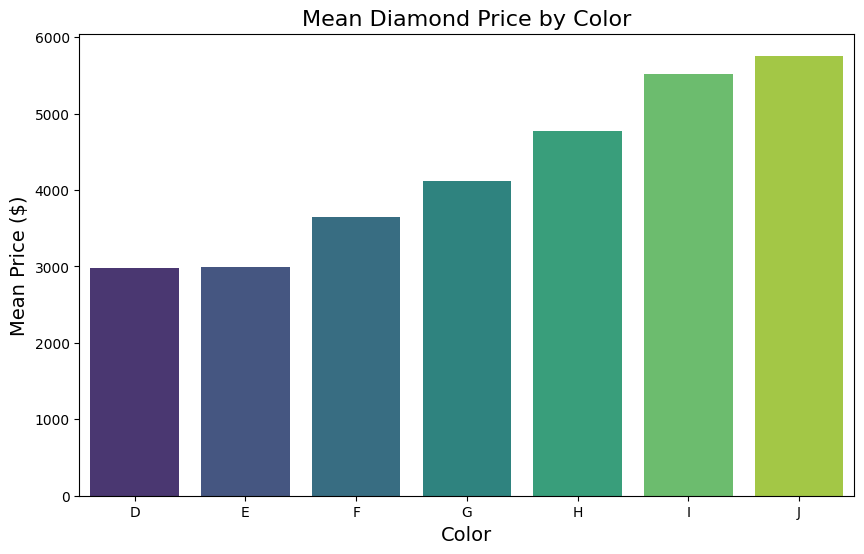

In [15]:
color_price_mean = df.groupby("color")["price"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x="color", y="price", data=color_price_mean, palette="viridis")

plt.title('Mean Diamond Price by Color', fontsize=16)
plt.xlabel('Color', fontsize=14)
plt.ylabel('Mean Price ($)', fontsize=14)

plt.show()

Color Grade Significance: The color of a diamond significantly impacts its price. Diamonds with higher color grades (closer to D) are considerably more expensive than those with lower color grades (closer to J).

## Hypothesis Testing

### Null Hypothesis (H0)
There is no difference in price between color D and color E.

### Alternative Hypothesis (H1)
There is a difference in price between color D and color E.

Text(0.5, 1.0, 'Distribution Price (Log) by Colors D and E')

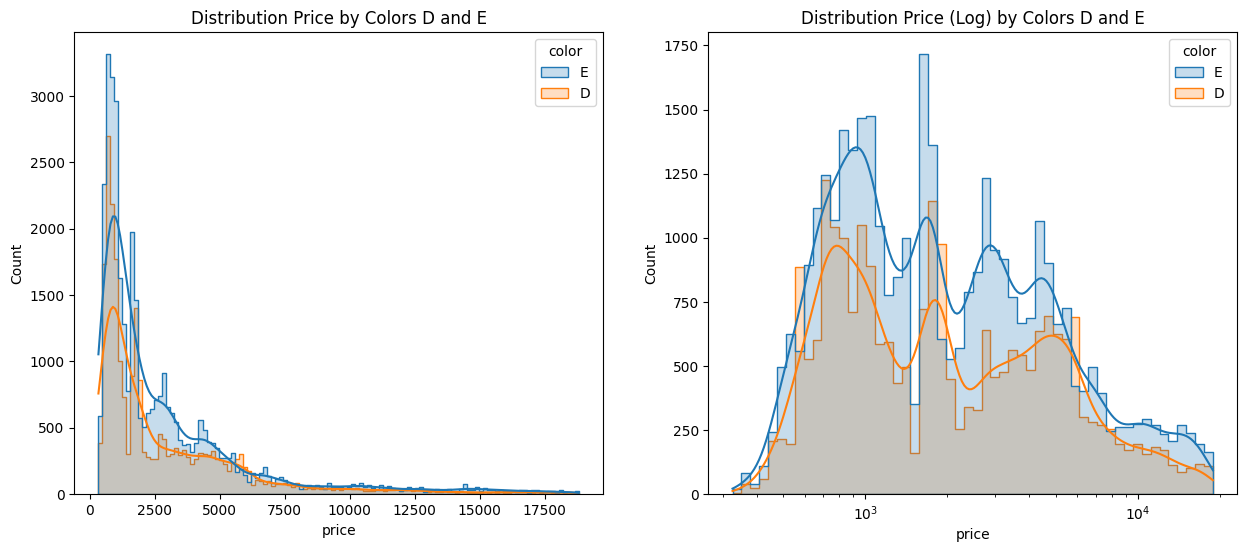

In [16]:
temp_d_e = df[df["color"].isin(["D","E"])]

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.histplot(
    data=temp_d_e,
    x="price",
    hue="color",
    kde=True,
    element="step"
).set_title("Distribution Price by Colors D and E")

plt.subplot(1,2,2)
sns.histplot(
    data=temp_d_e,
    x="price",
    hue="color",
    kde=True,
    element="step",
    log_scale=True
).set_title("Distribution Price (Log) by Colors D and E")

In [17]:
# calculate sample
def slovin(data:pd.DataFrame, feature:str,moe:float) -> pd.DataFrame:
    N = len(data)
    e = moe
    n = int(N / (1 + N * e**2))


    temp_proportion = data[feature].value_counts(normalize=True)
    sample_group    = (temp_proportion*n).round(2).astype(int)
    df_sample       = data.groupby(feature).apply(lambda x: x.sample(sample_group.loc[x.name], random_state=42)).reset_index(drop=True)
    return df_sample


temp_color_sample = slovin(temp_d_e,"color",0.05)
temp_color_sample["log_price"] = np.log(temp_color_sample["price"])
t_stats, p_value = ttest_ind(temp_color_sample[temp_color_sample.color=="D"]["log_price"], temp_color_sample[temp_color_sample.color=="E"]["log_price"])

if p_value < 0.05:
    print(f"Sufficient evidence to reject H0, indicating a difference in the average price between color D and E. P value {p_value}")
else:
    print(f"Insufficient evidence to reject H0, indicating no difference in the average price between color D and E. P value {p_value}")


Insufficient evidence to reject H0, indicating no difference in the average price between color D and E. P value 0.46969392782140884


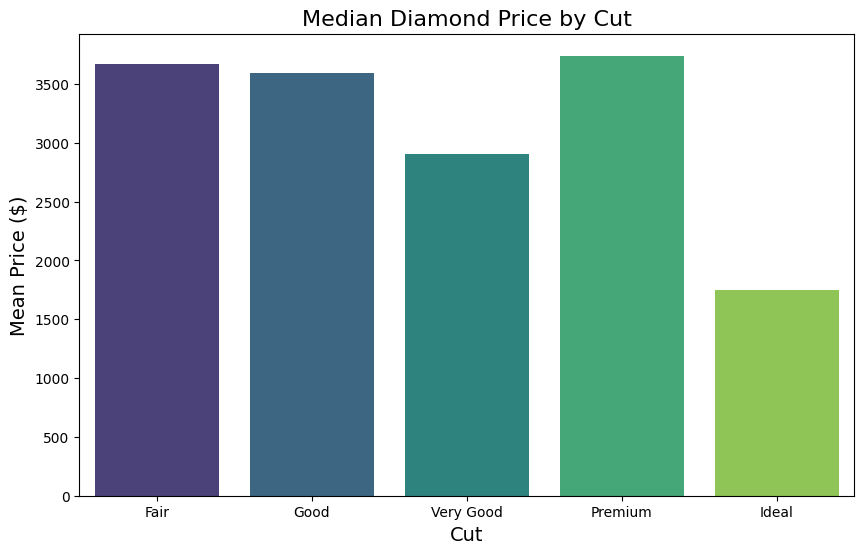

In [18]:
cut_price_median = df.groupby("cut")["price"].median().reset_index()
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
cut_price_median['cut'] = pd.Categorical(cut_price_median['cut'], categories=cut_order, ordered=True)
cut_price_median = cut_price_median.sort_values('cut')

plt.figure(figsize=(10, 6))
sns.barplot(x="cut", y="price", data=cut_price_median, palette="viridis")

plt.title('Median Diamond Price by Cut', fontsize=16)
plt.xlabel('Cut', fontsize=14)
plt.ylabel('Mean Price ($)', fontsize=14)

plt.show()

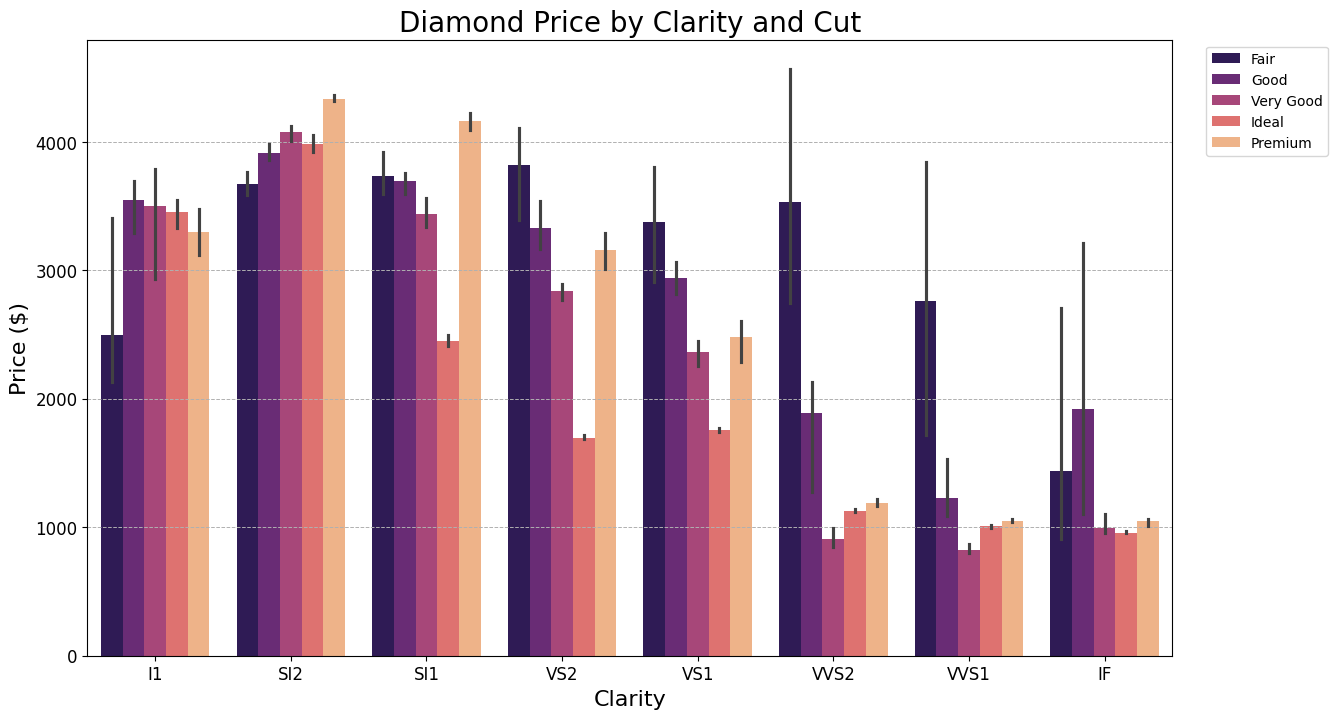

In [19]:
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df,
    x="clarity",
    y="price",
    hue="cut",
    order=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
    hue_order=["Fair", "Good", "Very Good", "Ideal", "Premium"],
    palette="magma",
    estimator="median"
)


plt.title('Diamond Price by Clarity and Cut', fontsize=20)
plt.xlabel('Clarity', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)
plt.legend(title='Cut', title_fontsize='13', fontsize='11')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend(bbox_to_anchor=(1.15,1))
plt.show()

1. **Clarity's Strong Impact:**
   - **General Trend:** Diamonds with lower clarity grades (more inclusions) such as I1 have lower median prices. As clarity improves (fewer inclusions), the median price of diamonds tends to increase.
   - **Notable Exception:** Clarity grade VS1 shows a relatively higher variation in prices, especially for diamonds with a "Fair" cut, indicating a wider range of prices within this clarity grade.

2. **Cut Grade's Influence:**
   - **Ideal and Premium Cuts:** For most clarity grades, diamonds with "Ideal" and "Premium" cuts generally have higher prices. This highlights the added value of superior cuts, which enhance the diamond's brilliance and appeal.
   - **Variability within Cuts:** Even within the same clarity grade, there is noticeable variability in prices across different cut grades. For example, in clarity grades SI1 and VS2, diamonds with "Very Good" and "Ideal" cuts have similar average prices, indicating that consumers may value both cuts similarly.

3. **Price Fluctuations:**
   - **Fair Cut:** Diamonds with a "Fair" cut consistently have lower prices across all clarity levels, reaffirming that fair-cut diamonds are less desirable due to their poorer light performance.
   - **VVS2 Clarity Grade:** For the VVS2 clarity grade, diamonds with "Premium" and "Ideal" cuts show significant price differences compared to other cuts, indicating a higher premium placed on superior cuts within this clarity grade.

4. **Higher End Clarity Premium:**
   - **VVS1 and IF Grades:** There is a marked price difference between the highest clarity grades (VVS1 and IF) and lower clarity grades. This indicates a premium for diamonds with very few inclusions, reflecting their rarity and desirability.


# Feature Engineering

<Axes: >

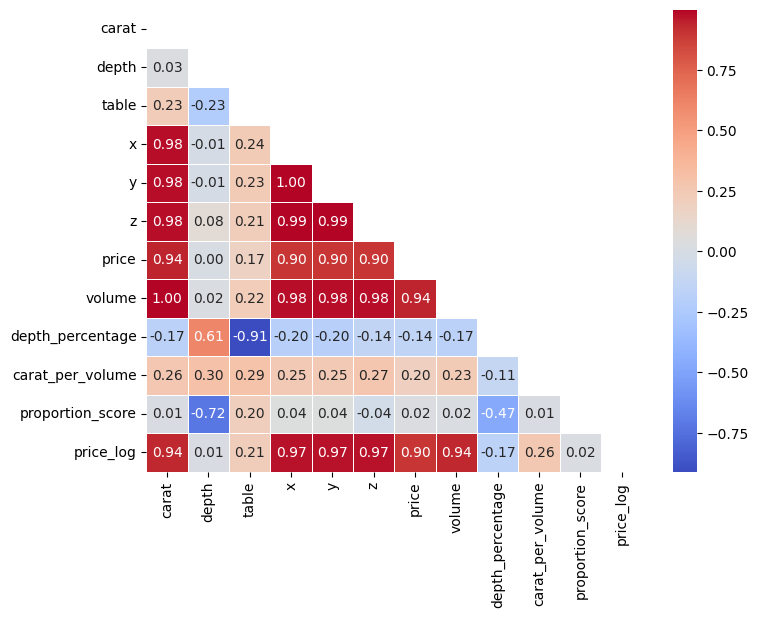

In [20]:
df["volume"] = df['x'] * df['y'] * df['z']
df['depth_percentage'] = (df['depth'] / df['table']) * 100
df['carat_per_volume'] = df['carat'] / df['volume']
df['proportion_score'] = (df['x'] / df['y']) * (df['x'] / df['z']) * (df['y'] / df['z'])
df["price_log"] = np.log(df["price"])

numeric = df.select_dtypes(exclude="O").columns.tolist()
numeric.remove("id")

corr_matrix = df[numeric].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, linewidths=.5, fmt=".2f")

## Feature Selection

In [21]:
drop_cols = ["x","y","z","proportion_score","volume","depth","depth_percentage","price_log"]
df = df.drop(drop_cols,axis=1)

df.head()

,id,carat,cut,color,clarity,table,price,carat_per_volume
0,0,1.52,Premium,F,VS2,58.0,13619,0.006269
1,1,2.03,Very Good,J,SI2,58.0,13387,0.006142
2,2,0.70,Ideal,G,VS1,57.0,2772,0.006134
3,3,0.32,Ideal,G,VS1,56.0,666,0.006113
4,4,1.70,Premium,G,VS2,59.0,14453,0.006122


# Preprocessing

In [22]:
#renew
con_var = [
    var for var in df.columns if df[var].dtype !="O" and df[var].nunique()>20 and var!="id" and var!="price"
]


cat_var = [
    var for var in df.columns if df[var].dtype =="O" 
]

# mapping
cut_map = ["Fair","Good","Very Good","Premium","Ideal"]

clarity_map = ["I1","SI2","SI1","VS2","VS1","VVS2","VVS1","IF"]

color_map = ["D","E","F","G","H","I","J"]

numerical_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',StandardScaler())
    ]
 )

cat_pipeline = Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy="most_frequent")),
        ('oridinalencoder',OrdinalEncoder(categories=[cut_map,color_map,clarity_map])),
        ('scaler',StandardScaler())
    ]
 )

processor = ColumnTransformer([
    ('numerical_pipeline',numerical_pipeline,con_var),
    ("categorical_pipeline",cat_pipeline,cat_var)
 ])

# Modelling

In [23]:
X = df.drop(["id","price"],axis=1)
y = np.log(df["price"])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

#-- processing applied ---
X_train = pd.DataFrame(processor.fit_transform(X_train),columns=X.columns)
X_test = pd.DataFrame(processor.transform(X_test),columns=X.columns)

In [29]:
def evaluation(models:Dict[str,object],X_train:pd.DataFrame,X_test:pd.DataFrame,y_train:pd.Series,y_test:pd.Series) -> pd.DataFrame:
    results = []
    for model_name,ml_func in models.items():
        ml_func.fit(X_train,y_train)
        pred_train      = ml_func.predict(X_train)
        pred_test       = ml_func.predict(X_test)

        r2_score_train  = r2_score(y_train,pred_train)
        r2_score_test   = r2_score(y_test,pred_test)

        rmse_train      = mean_squared_error(np.exp(y_train),np.exp(pred_train),squared=False)
        rmse_test       = mean_squared_error(np.exp(y_test),np.exp(pred_test),squared=False)

        results.append({
            "Model Name": model_name,
            "Model Function":ml_func,
            "R2 Score Train": r2_score_train,
            "R2 Score Test": r2_score_test,
            "RMSE Train": rmse_train,
            "RMSE Test": rmse_test
        })
    df_results = pd.DataFrame(results).sort_values(["R2 Score Test","RMSE Test"],ascending=[False,True]).reset_index(drop=True)
    df_results["Rank"] = df_results.index + 1
    return df_results
        
        
        

models = {
    "LinearRegression":LinearRegression(),
    "RidgeRegression":Ridge(random_state=42),
    "Lasso":Lasso(random_state=42),
    "RandomForestRegressor":RandomForestRegressor(random_state=42,max_depth=5),
    "XGBRegressor":XGBRegressor(random_state=42,max_depth=5)
}

evaluation_results = evaluation(models, X_train, X_test, y_train, y_test)
evaluation_results

,Model Name,Model Function,R2 Score Train,R2 Score Test,RMSE Train,RMSE Test,Rank
0,XGBRegressor,"XGBRegressor(base_score=None, booster=None, ca...",0.989393,0.988754,558.664115,580.953966,1
1,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=5, max_featur...",0.973196,0.972945,927.851330,934.030614,2
2,RidgeRegression,Ridge(random_state=42),0.901669,0.899478,5783.452735,7677.725927,3
3,LinearRegression,LinearRegression(),0.901669,0.899478,5783.660252,7677.571196,4
4,Lasso,Lasso(random_state=42),0.000000,-0.000007,4323.987821,4317.425515,5


**Model Ranking:**

1. **XGBRegressor:** This model is ranked the best overall. It has the highest R2 scores on both training and test sets (0.989 and 0.989 respectively), indicating it explains a large proportion of the variance in the target variable. It also has the lowest RMSE values, suggesting smaller errors in its predictions compared to other models.

2. **RandomForestRegressor:** This model performs very well, but slightly worse than XGBRegressor. It has high R2 scores and relatively low RMSE values, making it a strong contender.




In [32]:
best_model = evaluation_results[evaluation_results["Rank"]==1]["Model Function"][0]

best_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

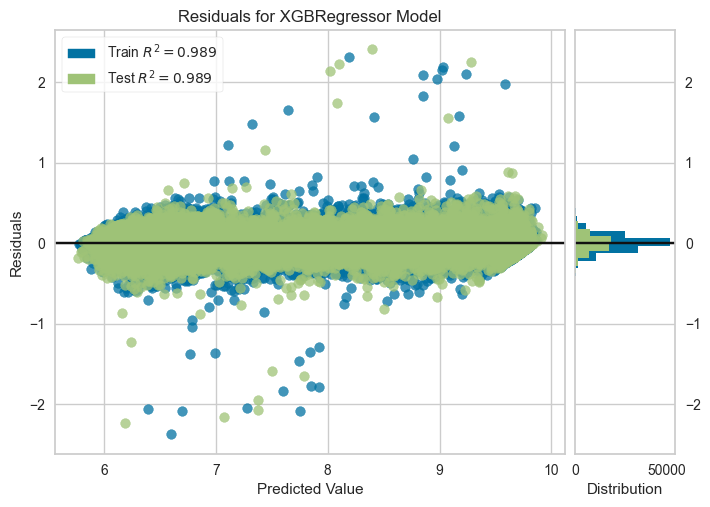

In [33]:
viz = residuals_plot(best_model, X_train, y_train, X_test, y_test)

**Residuals Plot (Left Side):**

* **Even Distribution:** The residuals are relatively evenly distributed around the horizontal line at zero. This indicates that the model is unbiased, meaning it's not systematically overpredicting or underpredicting the target variable.
* **Constant Variance:** The spread of the residuals remains relatively consistent across the range of predicted values. This is a good sign as it suggests that the model's accuracy doesn't vary significantly depending on the predicted value.
* **No Obvious Patterns:** There are no clear patterns or trends in the residuals. This indicates that the model has captured the underlying relationship between the predictor variables and the target variable reasonably well.
* **Few Outliers:** There are a few points that are further away from the zero line than the majority of the residuals, suggesting potential outliers in the data. However, these outliers don't seem to significantly impact the model's overall performance.

**Histogram of Residuals (Right Side):**

* **Approximately Normal:** The histogram of the residuals is roughly bell-shaped, indicating that the residuals are approximately normally distributed. This is a desirable property for regression models and helps to validate some statistical assumptions.




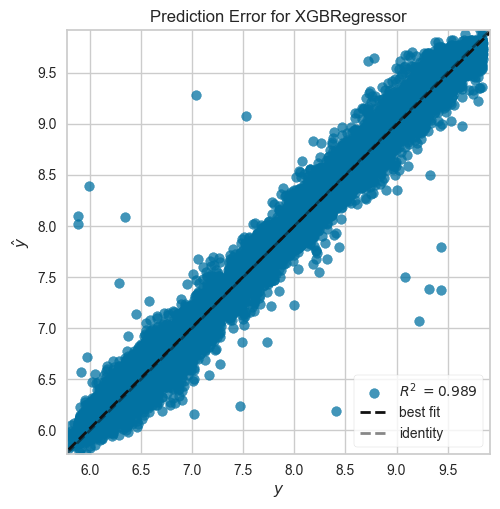

In [34]:
visualizer = prediction_error(best_model, X_train, y_train, X_test, y_test)

This plot demonstrates the XGBRegressor model's excellent performance in predicting diamond prices. It accurately captures the relationship between the features (carat, cut, clarity, etc.) and price, with minimal bias and consistent accuracy across different price ranges. This suggests the model is reliable and can be effectively used for diamond price prediction tasks.

<Axes: title={'center': 'Feature Importance'}>

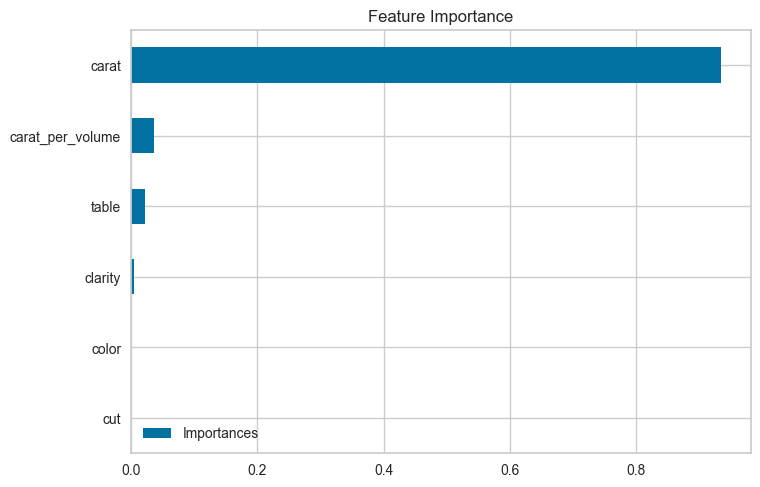

In [36]:
pd.DataFrame(
    best_model.feature_importances_,
    index=X_train.columns,
    columns=["Importances"]
).sort_values("Importances",ascending=True).plot(kind="barh",title="Feature Importance")

1. **Carat is Dominant:** The carat feature (weight of the diamond) is by far the most important factor in the model. This aligns with the common understanding that larger diamonds are generally more expensive.

2. **Carat per Volume:**  The second most important feature, "carat_per_volume," is a derived feature likely representing the density of the diamond. This suggests that the concentration of weight within a diamond's size also significantly affects its price. A higher carat per volume might indicate a denser and potentially more valuable diamond.

3. **Other Features Have Minor Impact:** The remaining features—table (width of the top of the diamond relative to its widest point), clarity, color, and cut—have relatively low importance scores. This implies that while these factors do contribute to the price, their influence is much smaller compared to carat and carat per volume.

**Key Takeaways:**

* Carat weight is the primary driver of diamond prices.
* The density of the diamond (carat per volume) plays a substantial secondary role.
* Other factors like cut, clarity, and color have a smaller impact on price compared to carat and density.

**Practical Implications:**

* **Buyers:** Focus on carat weight and carat per volume as the main indicators of a diamond's potential value.
* **Sellers:** Highlight carat weight and any indications of high density to justify a diamond's price.
